# Importing Libraries & Data

In [136]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats.mstats as ssm
from scipy.stats import gaussian_kde as kde
import random
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn import preprocessing

In [2]:
rawData=pd.read_csv('CrowdstormingDataJuly1st.csv')

# Visualizing rawData

In [3]:
rawData.ix[:10,:13]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,1,0,0
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,0,0,0


The definition of all the "column values" are described in DATA.md but let screen them here also: 

In [4]:
rawData.ix[:10,13:]

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,0,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,0,0,0,47704.jpg,0.00,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,0,0,0,22356.jpg,1.00,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
8,0,0,0,16528.jpg,0.25,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
9,0,0,0,36499.jpg,0.00,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


# Analyzing Data

After looking at the data, we realized that some referees had less than 22 Dayds which is technically impossible since at every game each referee receive at least 22 Dyads. So we decied to remove the referees with less than 22 Dyads

In [8]:
rawData.sort_values('refNum');
allRefs = len(rawData.refNum.value_counts())
allDyads = np.sum(rawData.games)

specRef=rawData
for i in range(allRefs):
    specRef1=specRef[specRef['refNum']==i] #we put dataframe of each referee into specRef1 as a temporary variable
    if(np.sum(specRef1['games'])<22):
        specRef=specRef.drop(specRef1.index)

In [10]:
specRef.head()  #specRef is now containing the new DataFrame without the referees with less than 22 Dyads, corresponding to one game as a referee.
specRef=specRef.reset_index(drop=True)  #To reset the index of the Dataframe

Now let's study the two parameters 'rater1' and 'rater2' to see their robustness to define if a player is "black" or "white". And to do so, lets visualize the two raters first.

In [50]:
specRef.ix[:10,17:19]

,rater1,rater2
0,0.25,0.00
1,0.00,0.25
2,1.00,1.00
3,0.25,0.25
4,0.00,0.00
5,0.00,0.00
6,0.50,0.50
7,0.00,0.00
8,0.00,0.00
9,0.00,0.25


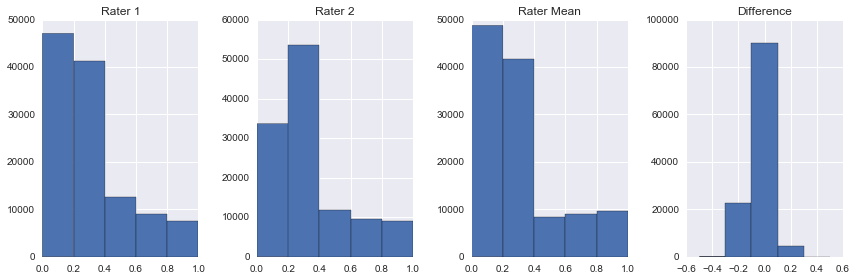

In [49]:
fig, ax = plt.subplots(1,4,figsize=(12, 4))
c = sns.color_palette()
ax[0].hist(specRef['rater1'].dropna().tolist(),bins = 5, range = (0,1), color = c[0])
ax[0].set_title('Rater 1')
ax[1].hist(specRef['rater2'].dropna().tolist(),bins = 5, range = (0,1), color = c[0])
ax[1].set_title('Rater 2')
ax[2].hist(((specRef['rater1']+specRef['rater2'])/2).dropna().tolist(),bins = 5, range = (0,1), color = c[0])
ax[2].set_title('Rater Mean')
ax[3].hist((specRef['rater1']-specRef['rater2']).dropna().tolist(),bins = 5, range = (-0.5,0.5), color = c[0])
ax[3].set_title('Difference')

fig.tight_layout()

We can see that the diffeence between the two parameters, is in general low. We can then conclude that this parameters can be used to define if a person is white or black.

Preparation Train/Test Dataframe

Machine Learning: Output skin color with a certain matrix!

In [13]:
#Add column with average
specRef=specRef.assign(Mean=(specRef['rater1']+specRef['rater2'])/2)
specRef.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,Mean
0,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
1,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
2,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000
3,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.250
4,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000


Give label to each row of the train dataset

In [14]:
specRef=specRef.assign(SkinColor=np.random.randn(len(specRef)))

for i in range(len(specRef)):
    if (specRef.iloc[i,28]<0.375):
        specRef.iloc[i,29]='white'
    elif(specRef.iloc[i,28]>0.675):
        specRef.iloc[i,29]='black'
    else:
        specRef.iloc[i,29]=np.nan
        
specRef.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,Mean,SkinColor
0,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,white
1,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,white
2,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000,black
3,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.250,white
4,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,white


In [173]:
specRef[specRef['playerShort']=='anders-lindegaard']



,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,Mean,SkinColor
3,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.25,white
7297,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,34,DNK,0.361010,2254.0,0.000179,0.614484,2306.0,0.000812,0.25,white
10278,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,44,ENGL,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037,0.25,white
19159,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,2,1,...,71,NOR,0.340606,4949.0,0.000083,0.692824,5212.0,0.000391,0.25,white
22954,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,0.25,white
23995,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,1,...,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,0.25,white
24720,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,2,1,...,44,ENGL,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037,0.25,white
30841,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,6,3,...,71,NOR,0.340606,4949.0,0.000083,0.692824,5212.0,0.000391,0.25,white
31390,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,102,SVN,0.273530,303.0,0.001426,0.429907,321.0,0.006084,0.25,white
38400,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,1,...,45,SCOT,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037,0.25,white


In [176]:
newSpecRef=specRef.dropna()
newSpecRef.head()

newSpecRef['Alpha_3'].unique()

array(['LUX', 'FRA', 'LBY', 'SGP', 'OMN', 'POL', 'CHE', 'JPN', 'IRL',
       'ENGL', 'SCOT', 'ESP', 'ARG', 'MKD', 'RUS', 'BLR', 'AUT', 'DEU',
       'BEL', 'GRC', 'ROU', 'ECU', 'ITA', 'ARE', 'BRA', 'IRN', 'ISR',
       'AZE', 'SWE', 'DNK', 'PRT', 'HRV', 'LVA', 'UKR', 'BGR', 'PRY',
       'FIN', 'USA', 'HUN', 'SEN', 'GMB', 'TUR', 'NLD', 'AUS', 'MEX',
       'SYC', 'SRB', 'MAR', 'NOR', 'GTM', 'CHL', 'GHA', 'WALES', 'BEN',
       'CYP', 'JAM', 'SVN', 'ZAF', 'URY', 'CAN', 'CMR', 'KOR', 'CZE',
       'SLV', 'BIH', 'SUR', 'GAB', 'EGY', 'LTU', 'PER', 'CHN', 'MDG',
       'EST', 'AGO', 'SVK', 'DZA', 'ZMB', 'PRI', 'CRI', 'ISL', 'COL',
       'HND', 'VEN', 'TUN', 'SDN', 'SAU', 'GEO', 'MUS', 'MLT', 'UGA',
       'BHR', 'TTO', 'MNE', 'CIV', 'LSO', 'NZL', 'BOL', 'UZB', 'PAN',
       'ALB', 'MYS', 'GIN'], dtype=object)

In [181]:
playerShortUnique=newSpecRef['playerShort'].unique()

for i in playerShortUnique:
    tab=specRef[specRef['playerShort']==i]
    dat=tab.ix[0,0:]
    
len(dat)

KeyError: 0

As we can see, by removing the mean of the rater which are included in between 0.375 and 0.625 we loose 15k dyads. So approximately 12% of the data.

# Test/Train

In [97]:
indexes = np.random.rand(len(newSpecRef)) < 0.8
train = newSpecRef[indexes]
test = newSpecRef[~indexes]
y=train['SkinColor']
ytest=test['SkinColor']

RandomForest

Encoding Categorical feature...

In [169]:
country=preprocessing.LabelEncoder()
country.fit(train['Alpha_3'])
list(country.classes_)
newValue=country.transform(train['Alpha_3'])
print(newValue)
X=train[['height', 'weight']]   #add or remove features
Xtest=test[['height','weight']]  #add or remove features

[56 56 56 ..., 44 44 44]


AttributeError: 'DataFrame' object has no attribute 'concat'

In [135]:
scoreIntermed=[]
score=[]
for i in range(1,4,1): #value of score decreace with value higher than 1
    for j in range(1,4,1):
        clf=RandomForestClassifier(max_depth=i, n_estimators=j, max_features=2)
        clf.fit(X, y)
        clf_probs = clf.predict_proba(Xtest)
        scoreIntermed.append(log_loss(ytest, clf_probs))
    score.append(scoreIntermed)
    scoreIntermed=[]
score

[[0.43499902298177129, 0.4360267178316608, 0.436027399261328],
 [0.43299364570858478, 0.43297174587018394, 0.43119596580844849],
 [0.42881629074503552, 0.42860231877493787, 0.42551025530964698]]

# Part 1 with K-NN, out of scope

Define features for classifying (I)

In [96]:
X=train[['height', 'weight']]   #add or remove features
Xtest=test[['height','weight']]   #add or remove features

K-NN Method (I) / BEST ONE

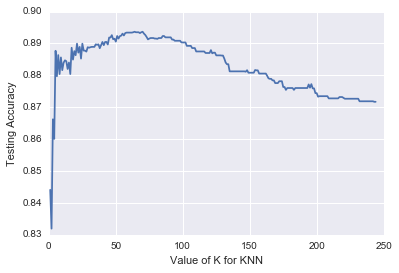

In [20]:
k_range = list(range(1, 100))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)
    ypredict = knn.predict(Xtest)
    scores.append(metrics.accuracy_score(ytest, ypredict))

%matplotlib inline
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')  

Max for value k=53 

In [21]:
knn = KNeighborsClassifier(n_neighbors=53)
knn.fit(X, y)
ypredict = knn.predict(Xtest)
print(metrics.accuracy_score(ytest, ypredict))

0.892295387897


Cross-validation on 20 Folds

In [23]:
scores = cross_val_score(knn, X, y, cv=20, scoring='accuracy')
cross_validation=scores.mean()
print(cross_validation) 

0.886904653129


Define features for classifying (II)

In [33]:
X=train[['height', 'weight','yellowCards','yellowReds']]   #add or remove features
Xtest=test[['height','weight','yellowCards','yellowReds']]   #add or remove features

K-NN Method (II) / OVERFITTING

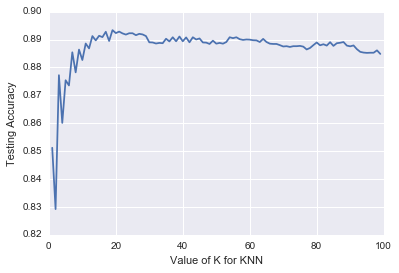

In [34]:
k_range = list(range(1, 40))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)
    ypredict = knn.predict(Xtest)
    scores.append(metrics.accuracy_score(ytest, ypredict))

%matplotlib inline
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')  

Max for value k=19

In [35]:
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X, y)
ypredict = knn.predict(Xtest)
print(metrics.accuracy_score(ytest, ypredict))

0.893361770195


Cross-validation on 20 folds

In [36]:
scores = cross_val_score(knn, X, y, cv=20, scoring='accuracy')
cross_validation=scores.mean()
print(cross_validation) 

0.885989065633


Results are a little bit lower than with the only two parameters: "height" and "weight"

Define features for classifying (III)

In [38]:
X=train[['yellowCards','yellowReds']]   #add or remove features
Xtest=test[['yellowCards','yellowReds']]   #add or remove features

K-NN Method (III) / Bad Parameters

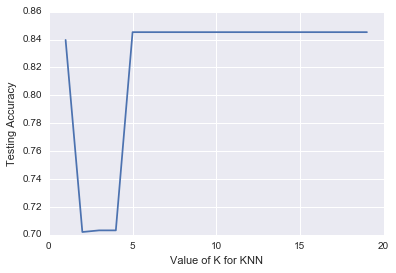

In [43]:
k_range = list(range(1, 10))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)
    ypredict = knn.predict(Xtest)
    scores.append(metrics.accuracy_score(ytest, ypredict))

%matplotlib inline
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')  

Max for value k=5

In [44]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)
ypredict = knn.predict(Xtest)
print(metrics.accuracy_score(ytest, ypredict))

0.845267928552


Cross-validation on 20 folds

In [45]:
scores = cross_val_score(knn, X, y, cv=20, scoring='accuracy')
cross_validation=scores.mean()
print(cross_validation) 

0.827439516498


We see that the result is still high, but that is still lower than the one with the parameters: 'height' and 'weight' 

CV(I)>CV(II)>CV(III)

Height/Weight is better than overfitting which is better than wrong parameters